Three primary insights

1) height must always be positive...

2) perhaps need velocity

3) perhaps need a mass, momentum flow model



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook
import matplotlib as mpl
import scipy.signal as signal
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

# Create a really dumb map, and work with it until erosion is complete and satisfactory

In [2]:
"The mysterius Island"

'The mysterius Island'

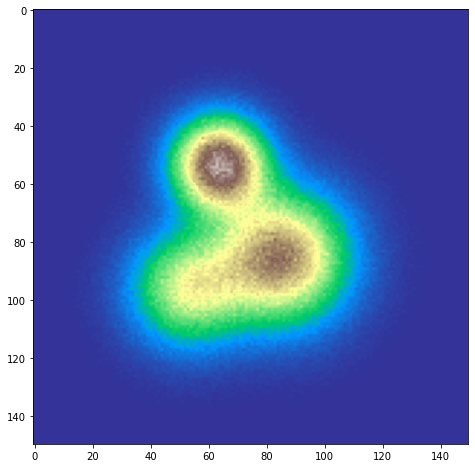

In [19]:
samples1 = np.random.multivariate_normal((6, 6), cov=np.eye(2)*2, size=1000000)
samples2 = np.random.multivariate_normal((3., 4.), cov=np.eye(2), size=600000)
samples3 = np.random.multivariate_normal((7, 3), cov=np.eye(2)*1.5, size=500000)
samples = np.concatenate((samples1, samples2, samples3))
bins = np.linspace(-2, 12, 151)
bcens = bins[:-1] + np.diff(bins) / 2
land = np.histogram2d(samples[:, 0], samples[:, 1], bins=(bins, bins))[0]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.imshow(land, cmap=plt.cm.terrain, vmin=0, vmax=1000)

making a few diagnostic slices

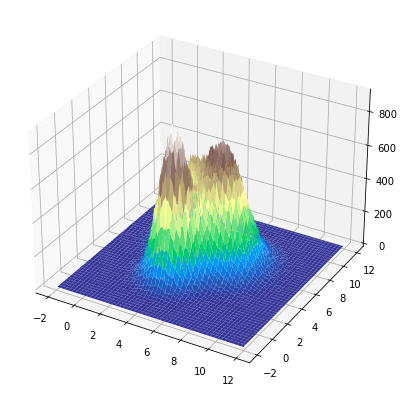

In [20]:
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111)

xx, yy = np.meshgrid(bcens, bcens)
zz = land.flatten()
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(7, 7))
ax.plot_surface(xx, yy, land, shade=True, cmap=plt.cm.terrain)
# ax = plt.axes(projection='3d')
plt.show()

# Flow water down the hill

In [21]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

def center_cut(arr):
    return arr[1:-1, 1:-1]

In [22]:
def pad(canvases):
    """padsfor each canvas pad the 2d array"""
    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        """
        Cell automata, considers the direct neighbor cells only
        
        Initialize with a dict of initial maps in the style
        
        initial_maps = {
            "layer_name": initial map,
        }
        
        The rules are a similar dictionary of class instances which will be passed 
        
        
        """
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key].copy())
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
#             dd = {key: [self.canvases[key],]}
            dd = {key: []}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for rule in self.rules:
            canvas = rule.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100, savestep=5):
        """
        a series of steps
        """
        self.reset_maps()
        self.update_maps()
        for i in np.arange(nstep):
#             print(str(i) + ' out of ' + str(nstep-1), end="\r")
            print(str(i) + ' out of ' + str(nstep-1), end="\n")
            self.step()
            if i % savestep == 0:
                self.update_maps()

In [157]:
class FlowRule(object):
    def __init__(self, flow_factor=0.5):
        """
        The way this automata is set up is with a walled boundary condition, matter can flow to the edges, but not out of it
        Therefore matter is conserved in the canvas. That's good
        
        An erosion factor of 1 makes a really unstable checkerboard behaviour, use smaller values for a balanced behaviour,
        """
        self.layers = np.sort(("terrain",))
        self.key = "terrain"
#         self.needed_keys ["terrain",]
        if flow_factor >= 1:
            raise ValueError("flow_factor must be less than 1, current value is {:.3f}".format(flow_factor))
        self.flow_factor = flow_factor
        
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
#         diffs[diffs < 0] = 0
        diffs[diffs < diffs.max(axis=0)] = 0. 
#         fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        
        outflow = diffs * self.flow_factor # this is the outgoing amount
#         print(outflow)
        height_local = self.calc_flows(height_local, outflow, cell)
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

    def calc_flows(self, vmap, outflow, cell):
        vmap -= outflow.sum(axis=0)
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            # the padding here is what restricts the landslide to the frozen boundary condition
            tmp = np.pad(outflow[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        vmap += shifted_landslide.sum(axis=0)        
        return vmap
         
        
class RainFall(FlowRule):
    def __init__(self, net_rainfall=0.5, rainmap=None):
        """
        This is adds new rain water to the water canvas
        
        Perhaps later this will be a non uniform rainfall pattern, once heat and cold is introduced to 
        account for evaporation
        
        rainmap is the characteristic rainfall pattern
        net rainfall is the amplitude of the rainmap
        """
        self.layers = np.sort(("water",))
        self.key = "water"
               
        self.net_rainfall = net_rainfall
        self.rainmap = rainmap
        
    def evolve(self,  cell):
        water_local = cell.canvases[self.key]
        
        if self.rainmap is not None:
            rainfall = self.rainmap * self.net_rainfall
        else:
            rainfall = np.ones(shape=water_local.shape) * self.net_rainfall
        water_local += rainfall
#         print(water_local)
        resdict = cell.canvases
        resdict.update({self.key: water_local})
        return resdict               
        

        
        
class Landslide(FlowRule):
    
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        outflow = diffs * fractions * self.flow_factor # this is the outgoing amount
        
        height_local = self.calc_flows(cell, height_local, outflow)
        
        resdict = cell.canvases
        resdict.update({self.key: height_local})
        return resdict

In [191]:
   
class WaterFlow(FlowRule):
    def __init__(self, water_flow_rate=0.5, land_coerosion_rate=0.1):
        """
        This is a two component erosion model where water flows fast, and drags a fraction of the land with it
        
        wflow_rate is the water flaw per time step
        lflow rate is the land coerosion per time step, this should be much smaller than the water flow rate
        
        The local gradient step is determined by the total land plus water height,
        and each component is dragged separately
        
        this is the lazy river approximation, where the velocity of water is negligible. Perhaps this is a mistake
        
        """
        self.layers = np.sort(("water", "terrain"))
        self.wkey = "water"
        self.lkey = "terrain"
        self.water_flow_rate = water_flow_rate
        self.land_coerosion_rate = land_coerosion_rate

                
    def evolve(self, cell):
#         np.set_printoptions(suppress=True)

        # these are the only canvases we are going to care about at all
        height_local = cell.canvases[self.lkey]
        height_shifted = cell.shifted_canvases[self.lkey]
        water_local = cell.canvases[self.wkey]
        water_shifted = cell.shifted_canvases[self.wkey]

        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
        
        outflow_w = water_local * fractions * self.water_flow_rate
        water_local = self.calc_flows(water_local, outflow_w, cell)
        
        # no more land can outflow than there is difference
        land_fraction = 
        outflow_l = height_local * outflow_w * self.land_coerosion_rate
        height_local = self.calc_flows(height_local, outflow_l, cell)

        resdict = cell.canvases
        resdict.update({self.wkey: water_local, self.lkey: height_local})
        
#         np.set_printoptions(suppress=False)
        return resdict    

In [196]:
# land
wmap = np.zeros(shape=land.shape)
wmap[65, 65] = 100

initial_maps = {
    "terrain": land,
    "water": wmap,
}
rules = (
#     RainFall(net_rainfall=0.32),
    WaterFlow(land_coerosion_rate=0.1, water_flow_rate=0.9),
#     Cleanup(ocean_map),
)


In [197]:
cs = CellSpace(initial_maps, rules)
cs.flow(200, savestep=5)
terrain = cs.maps["terrain"]
waters = cs.maps["water"]

0 out of 199
1 out of 199
2 out of 199
3 out of 199
4 out of 199
5 out of 199
6 out of 199
7 out of 199
8 out of 199
9 out of 199
10 out of 199
11 out of 199
12 out of 199
13 out of 199
14 out of 199
15 out of 199
16 out of 199
17 out of 199
18 out of 199
19 out of 199
20 out of 199
21 out of 199
22 out of 199
23 out of 199
24 out of 199
25 out of 199
26 out of 199
27 out of 199
28 out of 199
29 out of 199
30 out of 199
31 out of 199
32 out of 199
33 out of 199
34 out of 199
35 out of 199
36 out of 199
37 out of 199
38 out of 199
39 out of 199
40 out of 199
41 out of 199
42 out of 199
43 out of 199
44 out of 199
45 out of 199
46 out of 199
47 out of 199
48 out of 199
49 out of 199
50 out of 199
51 out of 199
52 out of 199
53 out of 199
54 out of 199
55 out of 199
56 out of 199
57 out of 199


/tmp/ipykernel_8733/1147760572.py:33: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(diffs / diffs.sum(axis=0))


58 out of 199
59 out of 199
60 out of 199
61 out of 199
62 out of 199
63 out of 199
64 out of 199
65 out of 199
66 out of 199
67 out of 199
68 out of 199
69 out of 199
70 out of 199
71 out of 199
72 out of 199
73 out of 199
74 out of 199
75 out of 199
76 out of 199
77 out of 199
78 out of 199
79 out of 199
80 out of 199
81 out of 199
82 out of 199
83 out of 199
84 out of 199
85 out of 199
86 out of 199
87 out of 199
88 out of 199
89 out of 199
90 out of 199
91 out of 199
92 out of 199
93 out of 199
94 out of 199
95 out of 199
96 out of 199
97 out of 199
98 out of 199
99 out of 199
100 out of 199
101 out of 199
102 out of 199
103 out of 199
104 out of 199
105 out of 199
106 out of 199
107 out of 199
108 out of 199
109 out of 199
110 out of 199
111 out of 199
112 out of 199
113 out of 199
114 out of 199
115 out of 199
116 out of 199
117 out of 199
118 out of 199
119 out of 199
120 out of 199
121 out of 199
122 out of 199
123 out of 199
124 out of 199
125 out of 199
126 out of 199
127 out

In [202]:
terrain[1].max()

4606.200000000001

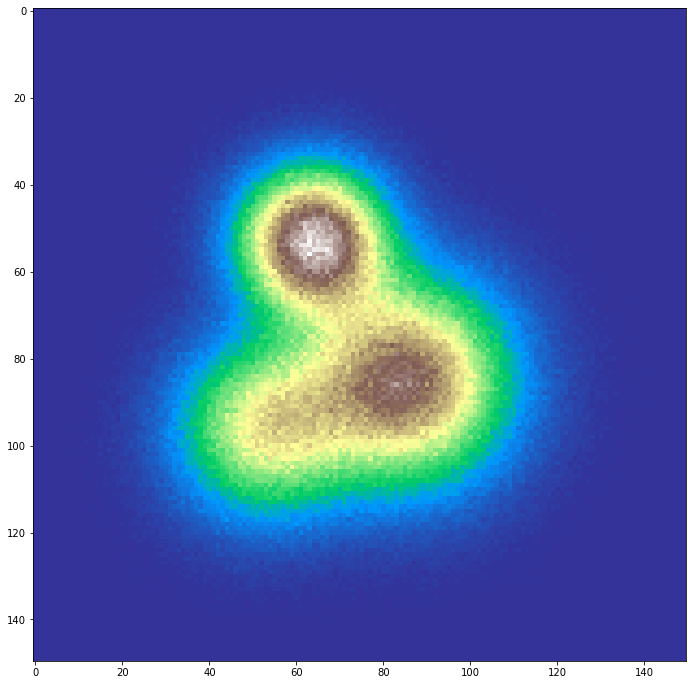

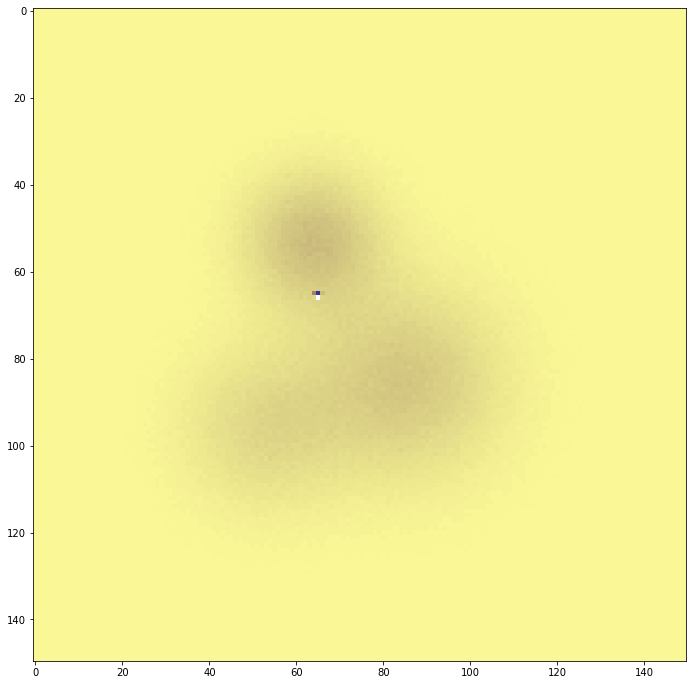

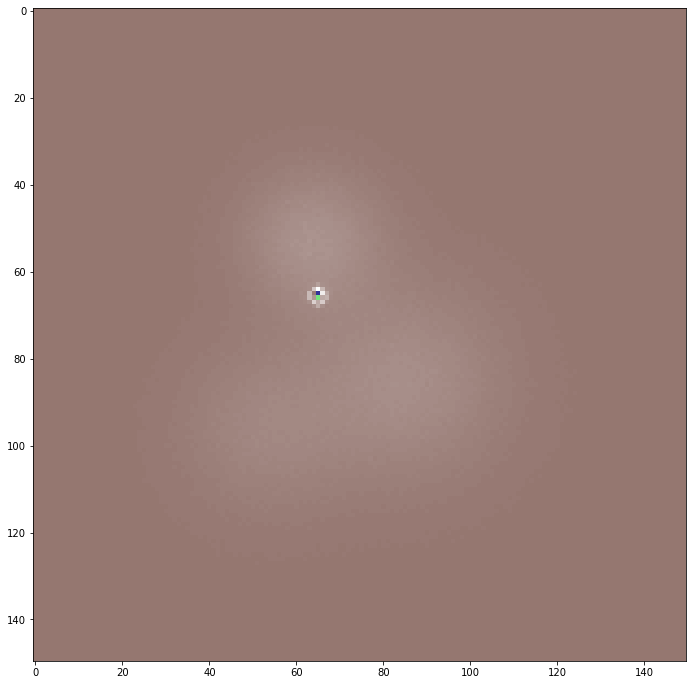

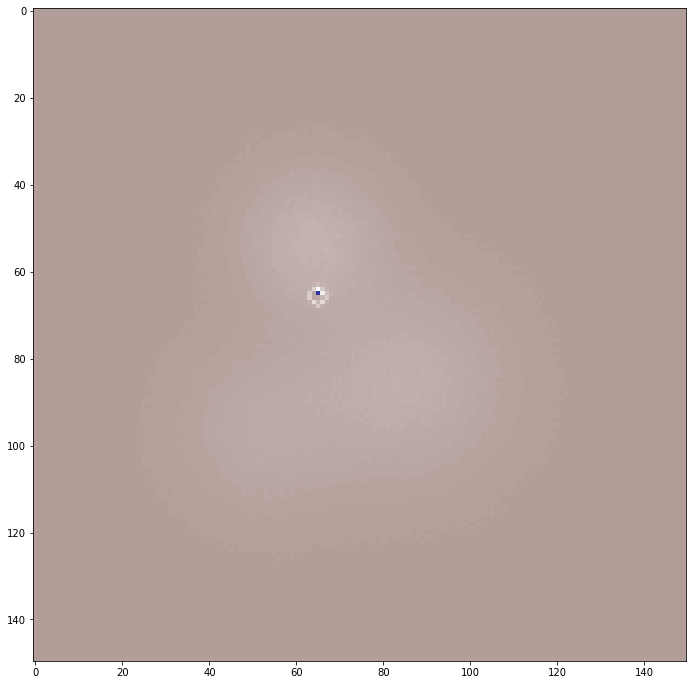

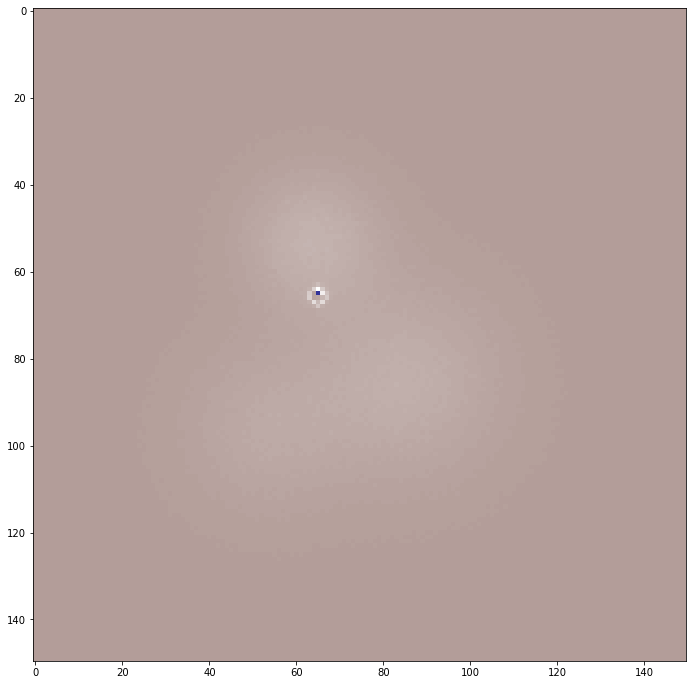

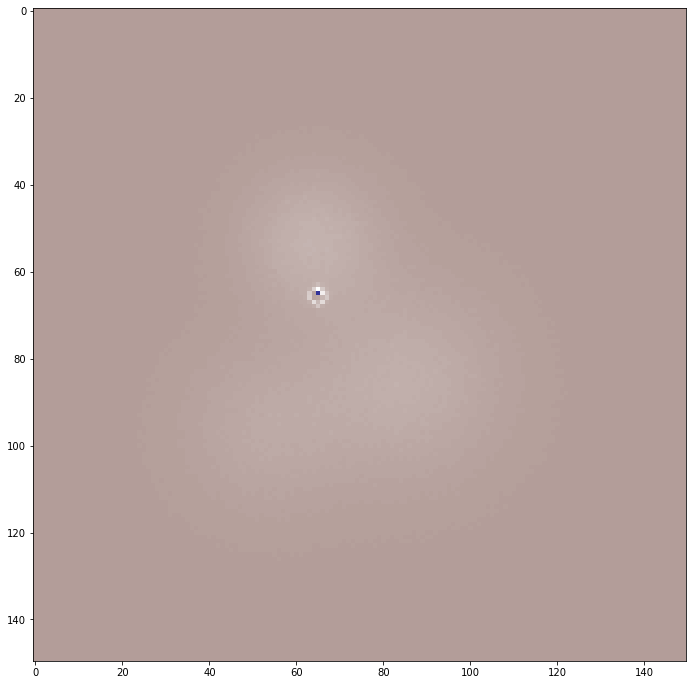

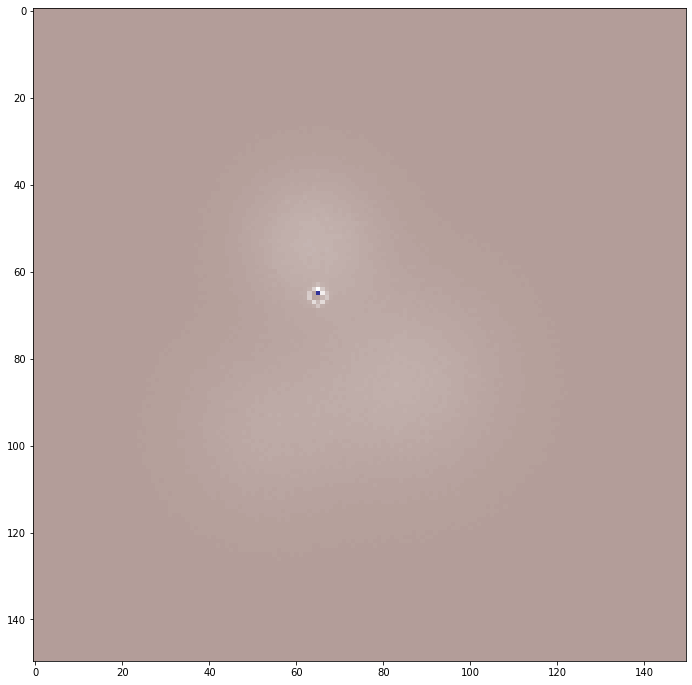

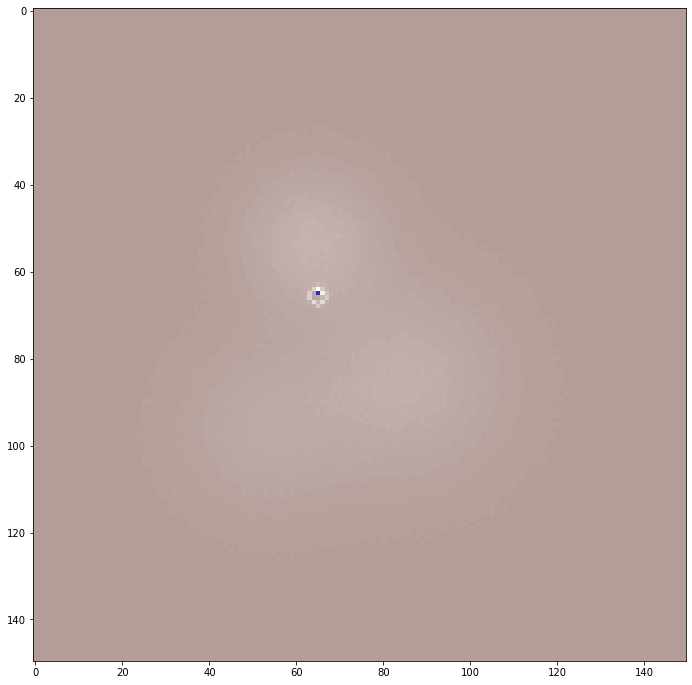

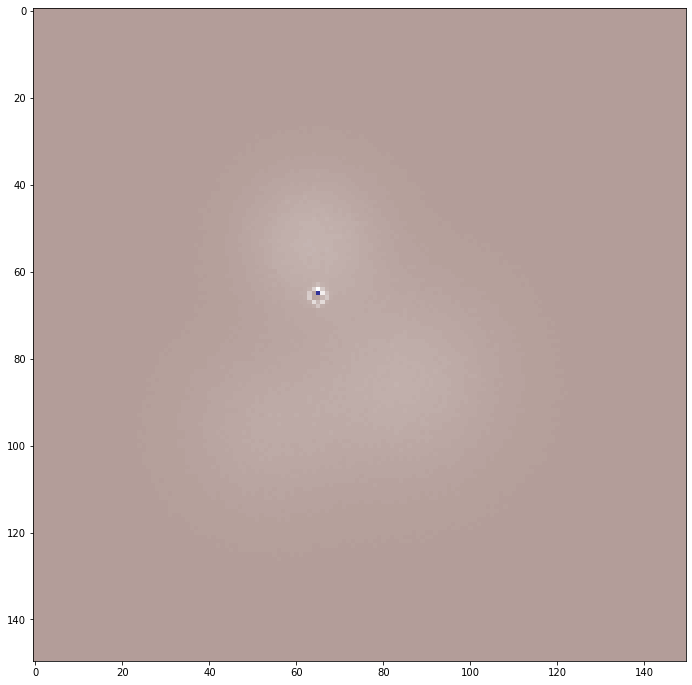

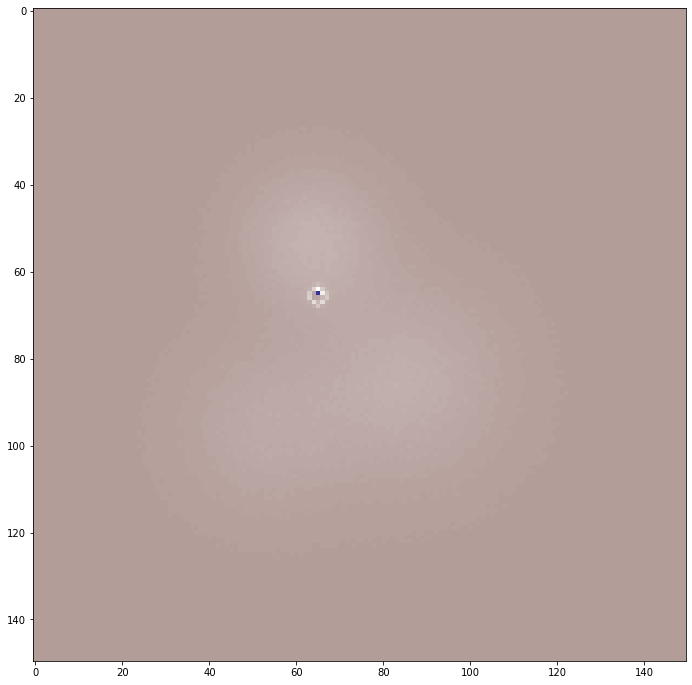

In [199]:
for i in np.arange(10):
# for i in np.ara
#     print(waters[i].max())
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    ax.imshow(terrain[i], cmap=plt.cm.terrain, )
#     alpha= (waters[i] > 0).astype(float) * 0.5
#     ax.imshow(waters[i], cmap=plt.cm.Blues, vmin=0, vmax=1)
#     ax = fig.add_subplot(111)
#     ax.imshow(terrain[i])